<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Dividend_Aristocrats_AgoraVAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa bibliotecas

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import datetime
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.core.series import Series



#Dividend Aristocrats

Os "Dividend Aristocrats" são uma seleção de empresas da S&P 500 que têm um histórico de pelo menos 25 anos consecutivos de aumento de seus pagamentos de dividendos. Este grupo de empresas é conhecido pela sua estabilidade financeira, qualidade gerencial e habilidade para gerar fluxos de caixa consistentes.

O índice "Dividend Aristocrats" é mantido pela Standard & Poor's (S&P), que reavalia a composição do índice anualmente.

As empresas que integram este índice representam uma ampla gama de setores, incluindo bens de consumo, saúde, industriais, entre outros. Além disso, elas são geralmente vistas como investimentos relativamente seguros e estáveis, especialmente em tempos de incerteza do mercado.

Investidores que buscam renda de dividendos recorrentes e consistentes, juntamente com potencial de apreciação do capital, muitas vezes consideram as ações dos Dividend Aristocrats como parte de suas estratégias de investimento.

## Preço Justo de Gordon e Graham

### Funções para gerar indicadores

In [2]:

def years_of_dividend_growth(ticker, year_of_test=None):
    """
    Função para calcular a quantidade de anos de crescimento dos dividendos para um ativo específico.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    year_of_test (int): Ano específico para testar. Se for None, o ano atual é usado.
    Retorna:
    int: A quantidade de anos consecutivos de crescimento de dividendos.
    """
    # Verifique se o ano de teste é fornecido ou determine o ano atual
    if year_of_test is None:
        current_year = datetime.now().year
        if datetime.now().month < 12:  # Se o ano ainda não está completo
            year_of_test = current_year - 1
        else:
            year_of_test = current_year
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verifique se os dividendos são uma série do Pandas
    if not isinstance(dividends, Series):
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return 0
    # Agregue os dividendos anuais e filtre pelo ano de teste
    dividends_annual = dividends.resample('Y').sum()
    dividends_annual = dividends_annual[dividends_annual.index.year <= year_of_test]
    # Contagem de anos de aumento de dividendos
    years_of_increase = 0
    for i in range(len(dividends_annual) - 1, 0, -1):
        if dividends_annual.iloc[i] > dividends_annual.iloc[i-1]:
            years_of_increase += 1
        else:
            break
    return years_of_increase


In [3]:

def years_of_consecutive_dividends(ticker, year_of_test=None):
    """
    Função para contar o número de anos consecutivos com dividendos pagos por um ativo específico.
    :param ticker: símbolo do ativo
    :param year_of_test: ano até o qual verificar os dividendos (opcional)
    :return: número de anos consecutivos com dividendos pagos
    """
    # Obtendo o ano, mês e dia atuais
    current_year = datetime.now().year
    current_month = datetime.now().month
    current_day = datetime.now().day
    # Determinando o ano de teste com base na data atual e verificando se o ano está completo
    if year_of_test is None:
        if current_month < 12 or (current_month == 12 and current_day < 31):  # Se o ano ainda não está completo
            year_of_test = current_year - 1
        else:
            year_of_test = current_year
    # Buscando os dados do ativo
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verificando se os dividendos estão disponíveis
    if not isinstance(dividends, Series):
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return 0
    # Resumindo os dividendos por ano
    dividends_annual = dividends.resample('Y').sum()
    # Filtrando os dividendos pelo ano especificado
    dividends_annual = dividends_annual[dividends_annual.index.year <= year_of_test]
    # Contando o número de anos consecutivos com dividendos
    years_of_dividends = 0
    for i in range(len(dividends_annual) - 1, 0, -1):
        if dividends_annual.iloc[i] > 0:
            years_of_dividends += 1
        else:
            break
    return years_of_dividends


In [4]:

def dividend_growth(ticker):
    """
    Função para calcular o crescimento de dividendos de um ativo específico em um e cinco anos.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    Retorna:
    one_year_growth (float): O crescimento dos dividendos em um ano, ou None se os dados não estiverem disponíveis.
    five_year_growth (float): O crescimento dos dividendos em cinco anos, ou None se os dados não estiverem disponíveis.
    """
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verifique se os dividendos são uma lista e se estão vazios
    if isinstance(dividends, list) and not dividends:
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return None, None
    # Agregue os dividendos anuais
    dividends_annual = dividends.resample('Y').sum()
    # Removendo o último ano se ele ainda não estiver completo
    if dividends_annual.index[-1].year == datetime.now().year:
        dividends_annual = dividends_annual.iloc[:-1]
    # Calcule o crescimento de dividendos de um ano, se disponível
    one_year_growth = None
    if len(dividends_annual) > 1:
        one_year_growth = (dividends_annual.iloc[-1] / dividends_annual.iloc[-2]) - 1
    # Calcule o crescimento de dividendos de cinco anos, se disponível
    five_year_growth = None
    if len(dividends_annual) > 5:
        five_year_growth = (dividends_annual.iloc[-1] / dividends_annual.iloc[-6])**(1/5) - 1
    return one_year_growth, five_year_growth


In [5]:
def get_additional_data(ticker):
    """
    Função para obter dados adicionais de um ativo específico, como dividendos por ação (TTM),
    valor de mercado, relação P/L, proporção de pagamento, beta, 52 semanas de alta e 52 semanas de baixa.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    Retorna:
    tuple: Uma tupla contendo os valores para os dados adicionais listados acima.
    """
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    info = stock.info
    # Recupere os dividendos por ação no último ano
    dividends_per_share_ttm = info.get('trailingAnnualDividendRate')
    # Recupere o valor de mercado e converta para milhões
    market_cap = info.get('marketCap')
    market_cap_m = market_cap / 1_000_000 if market_cap else None
    # Recupere outras informações financeiras relevantes
    trailing_pe_ratio = info.get('trailingPE')
    payout_ratio = info.get('payoutRatio')
    beta = info.get('beta')
    _52_week_high = info.get('fiftyTwoWeekHigh')
    _52_week_low = info.get('fiftyTwoWeekLow')
    return dividends_per_share_ttm, market_cap_m, trailing_pe_ratio, payout_ratio, beta, _52_week_high, _52_week_low


In [6]:
def gordon_price(D, k, g):
    """
    Calcula o preço justo de um ativo usando o modelo de Gordon Growth.

    Parâmetros:
    D (float): Dividendos por ação.
    k (float): Taxa de desconto.
    g (float): Taxa de crescimento dos dividendos.

    Retorna:
    float: Preço justo de Gordon.
    """
    return D / (k - g) if D != None else None


In [7]:
def graham_price(eps, bvps):
    """
    Calcula o preço justo de um ativo usando a fórmula de Graham.

    Parâmetros:
    eps (float): Lucro por ação.
    bvps (float): Valor contábil por ação.

    Retorna:
    float: Preço justo de Graham.
    """
    return (22.5 * eps * bvps) ** 0.5 if 22.5 * eps * bvps > 0 else None


#### TTM (Trailing Twelve Month)
#### Trailing P/E Ratio = Current Share Price / Trailing 12-Month EPS

In [8]:
# Lista de Dividend Aristocrats
# dividend_aristocrats = ['JPM', 'USB', 'PFE', 'WMB', 'KHC', 'KO','ALB','O']
dividend_aristocrats = ['FRT',  'EMR',  'ALB',  'NUE', 'XOM',  'CVX',  'AFL',  'ADM', 'ED', 'CINF',
                        'CB', 'CHRW', 'LEG', 'AMCR', 'EXPD', 'CAT',  'TROW',  'NEE',  'ROP', 'GPC',
                        'BEN', 'GD', 'SWK', 'DOV', 'GWW', 'LOW', 'ATO', 'TGT', 'PNR', 'HRL', 'SYY',
                        'ITW', 'KO', 'PPG', 'PG', 'MCD', 'KMB', 'NDSN', 'BRO', 'APD', 'ESS', 'MDT',
                        'ADP', 'SHW', 'PEP',  'LIN', 'AOS', 'MKC', 'JNJ', 'ABBV', 'ABT', 'CTAS',
                        'WMT', 'CL', 'BF.B', 'ECL', 'O', 'BDX', 'CAH', 'CHD', 'SPGI', 'WST',
                        'IBM', 'CLX', 'MMM', 'SJM', 'WBA']
# dividend_aristocrats = ['ALB','KO', 'CL', 'BF.B', 'O','WBA']
# dividend_aristocrats

##Gera arquivo com indicadores

In [9]:
# Registrar o tempo de início
start_time = time.time()
# Formata o tempo de início como uma string
formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
print(f"Tempo de início: {formatted_start_time}")

#Cria o arquivo
data = pd.DataFrame(columns=['Ativo', 'Nome', 'Setor', 'Preço atual', 'DY', 'DY Anos Sucessivos', 'DY Anos Crescendo', '1-Ano Dividendo crescimento', '5-Ano Dividendo crescimento (a.a.)',
                             'Dividendos Por Ação (TTM)', 'Valor de Mercado ($MM)', 'P/L', 'Payout', 'Beta', '52-Semana Alta', '52-Semana Baixa',
                             'Preço justo de Gordon', 'Preço justo de Graham'])

k = 0.1  # taxa de desconto
g = 0.05  # taxa de crescimento dos dividendos

for ticker in dividend_aristocrats:
  try:
    stock = yf.Ticker(ticker)
    info = stock.info

    name = info.get('shortName', "Nome não disponível")
    sector = info.get('sector', "Setor não disponível")

    history = stock.history()
    current_price = history.tail(1)['Close'].iloc[0] if not history.empty else None

    # Se o preço atual for None, continue para a próxima iteração
    if current_price is None:
        continue

    dy = info.get('dividendYield', None) * 100 if 'dividendYield' in info else None

    # Preço justo de Gorden e Graham
    D = info.get('dividendRate', None)
    eps = info.get('trailingEps', None)
    bvps = info.get('bookValue', None)

    gordon_price_value = gordon_price(D, k, g)
    graham_price_value = graham_price(eps, bvps)

    years_increase = years_of_dividend_growth(ticker)
    years_consecutive = years_of_consecutive_dividends(ticker)
    one_year_growth, five_year_growth = dividend_growth(ticker)
    additional_data = get_additional_data(ticker)

    new_row = pd.DataFrame({'Ativo': [ticker], 'Nome': [name], 'Setor': [sector], 'Preço atual': [current_price], 'DY': [dy], 'DY Anos Sucessivos': [years_consecutive],
                            'DY Anos Crescendo': [years_increase], '1-Ano Dividendo crescimento': [one_year_growth], '5-Ano Dividendo crescimento (a.a.)': [five_year_growth],
                            'Dividendos Por Ação (TTM)': [additional_data[0]], 'Valor de Mercado ($MM)': [additional_data[1]], 'P/L': [additional_data[2]],
                            'Payout': [additional_data[3]], 'Beta': [additional_data[4]], '52-Semana Alta': [additional_data[5]], '52-Semana Baixa': [additional_data[6]],
                            'Preço justo de Gordon': [gordon_price_value], 'Preço justo de Graham': [graham_price_value]
                            })
    data = pd.concat([data, new_row], ignore_index=True)
  except Exception as e:
      print(f"Erro ao processar o ativo {ticker}: {e}")
      continue

# Após a construção do DataFrame, converter a coluna para numérico:
data['Preço justo de Graham'] = pd.to_numeric(data['Preço justo de Graham'], errors='coerce')

# Registrar o tempo de término
end_time = time.time()

# Formata o tempo de término como uma string
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

# Calcula o tempo total de execução
execution_time = end_time - start_time

# Imprime os tempos formatados
print(f"Tempo de término: {formatted_end_time}")
print(f"Tempo total de execução: {execution_time:.6f} segundos")


Tempo de início: 2023-08-16 13:31:12
Erro ao processar o ativo CAT: unsupported operand type(s) for *: 'float' and 'NoneType'


ERROR:yfinance:BF.B: No price data found, symbol may be delisted (period=1mo)


Tempo de término: 2023-08-16 13:36:28
Tempo total de execução: 316.308743 segundos


In [10]:

#########################
corte = 0 # Defina o valor do corte
#########################
# Filtra o DataFrame para incluir apenas as linhas com 'DY Anos Sucessivos' maior que o corte
data_filtered = data.loc[data['DY Anos Sucessivos'] >= corte]
# Ordena o DataFrame filtrado como desejado
rank1 = 'DY'; rank2 = 'DY Anos Sucessivos'; rank3 = 'DY Anos Crescendo';  rank4 = 'P/L'

data_sorted = data_filtered.sort_values(
    by=[rank2, rank3, rank1, rank4],
    ascending=[False, False, False, True])
# Exportar em formato brasileiro
data_sorted.to_csv('DividendAristocrats.csv', sep=';', decimal=',', index=False)
data_sorted.head()


,Ativo,Nome,Setor,Preço atual,DY,DY Anos Sucessivos,DY Anos Crescendo,1-Ano Dividendo crescimento,5-Ano Dividendo crescimento (a.a.),Dividendos Por Ação (TTM),Valor de Mercado ($MM),P/L,Payout,Beta,52-Semana Alta,52-Semana Baixa,Preço justo de Gordon,Preço justo de Graham
47,JNJ,Johnson & Johnson,Healthcare,173.470001,2.74,60,60,0.062053,0.060338,4.58,450840.657920,35.189655,0.929,0.540353,181.04,150.11,95.2,56.642693
31,KO,Coca-Cola Company (The),Consumer Defensive,60.529999,3.02,60,52,0.047619,0.035262,1.80,261810.061312,26.669603,0.7469,0.537235,65.47,54.02,36.8,17.529039
4,XOM,Exxon Mobil Corporation,Energy,108.910004,3.31,60,39,0.017192,0.030152,3.61,440401.821696,7.375084,0.2888,1.077935,119.92,83.89,72.8,128.545181
8,ED,"Consolidated Edison, Inc.",Utilities,87.929703,3.62,60,34,0.019355,0.027438,3.20,30509.381632,12.559201,0.4591,0.360581,102.21,78.10,64.8,97.668869
60,IBM,International Business Machines,Technology,141.899994,4.68,60,27,0.040405,0.031604,6.61,129385.627648,60.180084,2.8128,0.854866,153.21,115.55,132.8,35.972865


##Histórico de Dividendos das top "n" maiores DY

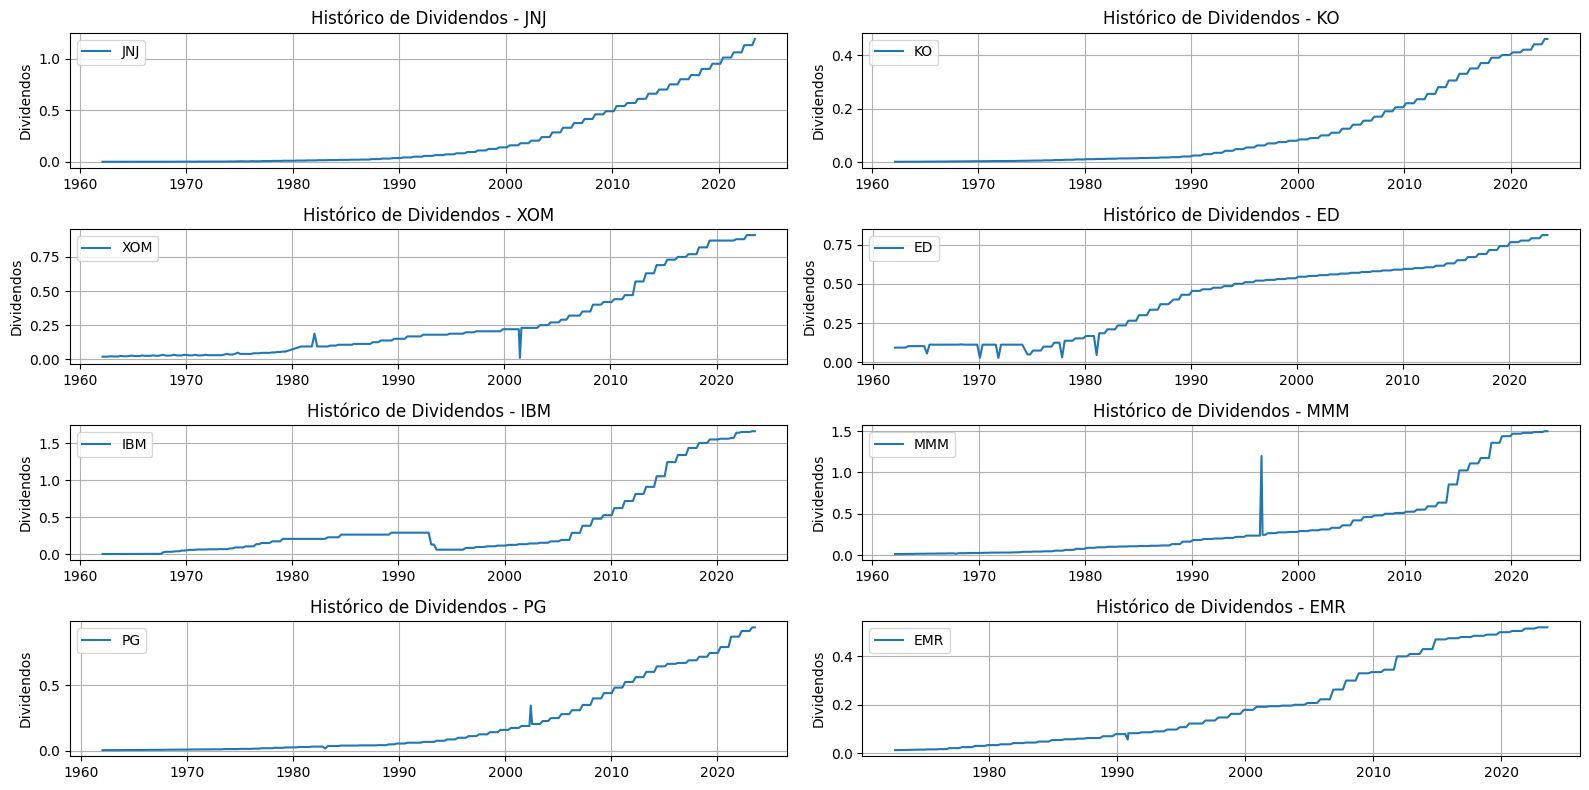

In [11]:
n = 8 ### Altere para diferentes quantidades. ATENÇÃO: use números pares e altere nrows para mostrar as quantidades que preferir
# Selecionar os cinco principais ativos
top_tickers = data_sorted['Ativo'].head(n)

# Definir o número de linhas e colunas
nrows = 4  ### altere aqui para adequar a visualização
ncols = 2
# Criar uma figura e um conjunto de subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 8))

# Para cada ativo, obter o histórico de dividendos e criar um gráfico
for i, ticker in enumerate(top_tickers):
    # Determine em qual subplot o gráfico deve ir
    row = i // ncols
    col = i % ncols
    # Obtenha o eixo para esse subplot
    ax = axs[row, col]

    stock = yf.Ticker(ticker)
    dividends = stock.dividends

    ax.plot(dividends.index, dividends, label=ticker)
    # ax.set_xlabel("Data")
    ax.set_ylabel("Dividendos")
    ax.set_title(f"Histórico de Dividendos - {ticker}")
    ax.legend()
    ax.grid(True)
# Ajustar o layout para evitar sobreposições
plt.tight_layout()
plt.show()

##Distribuição de setores dos ativos de Dividend Aristocrats

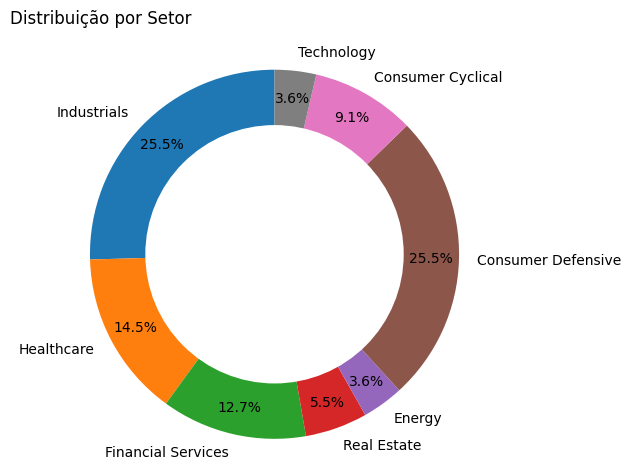

In [12]:
# Agrupar por setor e contar o número de empresas em cada um
sector_counts = data['Setor'].value_counts()

# Ordenar os dados de modo alternado entre setores grandes e pequenos
sorted_counts = pd.concat([pd.Series(sector_counts[::2]), pd.Series(sector_counts[1::4])])

# Criar gráfico de rosca
fig, ax = plt.subplots()
ax.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Igualar aspecto para garantir que a torta seja desenhada como um círculo
ax.axis('equal')

# Adicionar o título
plt.title("Distribuição por Setor", loc='left', pad=20)

plt.tight_layout()
plt.show()


##Histórico das top "n" pagadoras de dividendos.
Mudar a quantidade no comando top_10 = data_sorted.head(10) caso ver mais ou menos empresas;


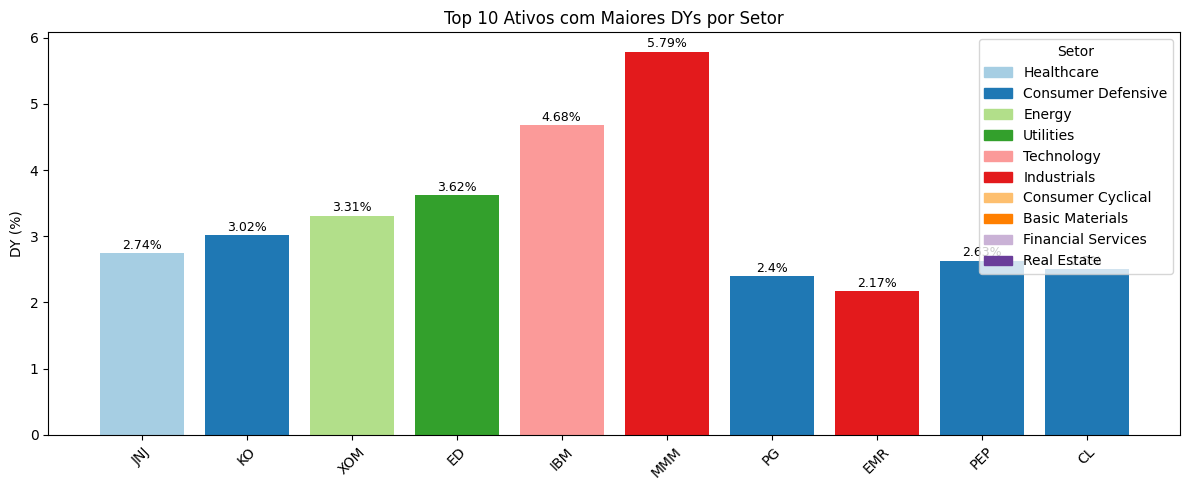

In [13]:
# Pegamos uma lista de cores do matplotlib
colors = plt.get_cmap('Paired').colors # tab20, Paired, Set3: outras paletas de cores.
# Obtemos uma lista dos setores únicos
sectors = data_sorted['Setor'].unique()
# Criamos um dicionário que mapeia cada setor a uma cor diferente
color_dict = {sector: colors[i] for i, sector in enumerate(sectors)}
# Adicionamos uma nova coluna ao dataframe com as cores correspondentes
data_sorted['Color'] = data_sorted['Setor'].map(color_dict)
################################
n = 10                   ####### Altere a quantidade
################################
# Selecionamos os top n e fazemos uma cópia do resultado
top_n = data_sorted.head(n).copy()
top_n['DY'] = top_n['DY'].fillna(0)  # Substituir NaN por 0

fig, ax = plt.subplots(figsize=(12, 5))
# Criamos o gráfico de barras, passando a coluna de cores para o argumento 'color'
bars = plt.bar(top_n['Ativo'], top_n['DY'], color=top_n['Color'])
# # Adicionamos os valores dos DYs no topo das barras
for bar in bars:
    # Aumentar o valor adicionado a yval
    yval = bar.get_height()
    # Parâmetro 'fontsize' - altere para melhorar a visualição dos rótulos
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{round(yval, 2)}%', ha='center', va='bottom', fontsize=9)
# Criamos uma legenda customizada
handles = [plt.Rectangle((0,0),1,1, color=color_dict[sector]) for sector in sectors]
plt.legend(handles, sectors, title='Setor')
plt.title(f'Top {n} Ativos com Maiores DYs por Setor') # Adicionando a variável n no título
# plt.xlabel('Ativo')
plt.ylabel('DY (%)')  # adicionado o símbolo de percentagem

plt.xticks(rotation=45)
# plt.xticks(fontsize=6)
ticks = ax.get_xticks()
# Obtendo os rótulos atuais do eixo X
labels = top_n['Ativo']
# Selecionando apenas cada n-ésimo rótulo
# mostra apenas cada n-ésimo rótulo
n = 1  ################# Altere o número, caso a visualição esteja ruim
plt.xticks(ticks[::n], labels[::n])

plt.tight_layout()
plt.show()


# ETF do Dividend Aristocrats - NOBL
NOBL é a sigla para ProShares S&P 500® Dividend Aristocrats® ETF. Trata-se de um fundo negociado em bolsa (ETF) que acompanha o índice S&P 500 Dividend Aristocrats. O objetivo deste ETF é replicar, antes das taxas e despesas, o desempenho do referido índice.

O Índice S&P 500 Dividend Aristocrats, que o NOBL procura replicar, é composto por empresas que são membros do S&P 500 e têm aumentado seus dividendos anualmente durante os últimos 25 anos consecutivos. O índice é ponderado por dividendos, o que significa que as empresas que pagam mais dividendos têm maior representação no índice.

Empresas que podem manter e aumentar seus pagamentos de dividendos ao longo do tempo são geralmente bem administradas e financeiramente estáveis, o que pode tornar o NOBL atraente para os investidores que buscam uma combinação de apreciação de capital e renda de dividendos.

Os Dividend Aristocrats são vistos como empresas com excelente saúde financeira e fortes perspectivas de crescimento. O ETF NOBL dá aos investidores uma maneira de investir nessas empresas sem ter que comprar individualmente cada uma delas.

Como qualquer investimento, o NOBL apresenta riscos, incluindo o risco de que as empresas no índice parem de pagar ou reduzam seus dividendos. Além disso, como o NOBL investe em um índice ponderado por dividendos, ele pode ter maior exposição a setores específicos do mercado que são conhecidos por pagar dividendos maiores, como o setor de bens de consumo básico ou o setor financeiro.

Por fim, é importante notar que, embora o NOBL seja baseado em empresas dos EUA, ele pode ser negociado internacionalmente e está sujeito a flutuações cambiais, entre outros fatores. Portanto, sempre é aconselhável fazer uma pesquisa adequada ou consultar um consultor financeiro antes de tomar a decisão de investir.

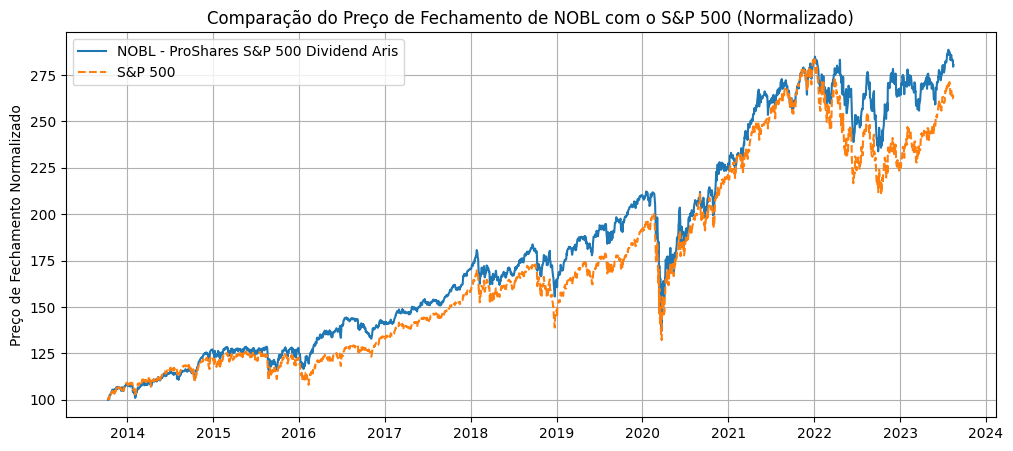

In [14]:
# import yfinance as yf
# import matplotlib.pyplot as plt

ativo = "NOBL"  # Insira o ativo aqui!
# Baixar os dados do ativo
ticker = yf.Ticker(ativo)

# Obter o histórico de preços do ativo
history = ticker.history(period="30y")
# Obter o nome da empresa
company_name = ticker.info['shortName']

# Baixar os dados do índice S&P 500 (o ticker é "^GSPC")
sp500_ticker = yf.Ticker("^GSPC")
sp500_history = sp500_ticker.history(period="30y")

# Encontrar as datas comuns às duas séries e usar apenas essas datas
common_dates = history.index.intersection(sp500_history.index)
history_common = history.loc[common_dates]
sp500_common = sp500_history.loc[common_dates]

# Normalizar os preços para que comecem em 100
history_common['Close'] = 100 * history_common['Close'] / history_common['Close'].iloc[0]
sp500_common['Close'] = 100 * sp500_common['Close'] / sp500_common['Close'].iloc[0]

# Plotar o preço de fechamento do ativo
plt.figure(figsize=(12,5))
plt.plot(history_common['Close'], label=f'{ticker.ticker} - {company_name}')

# Plotar o preço de fechamento do S&P 500
plt.plot(sp500_common['Close'], label='S&P 500', linestyle='--')

plt.title(f'Comparação do Preço de Fechamento de {ticker.ticker} com o S&P 500 (Normalizado)')  # Título atualizado
plt.ylabel('Preço de Fechamento Normalizado')
plt.grid(True)
plt.legend()  # Adicionar uma legenda
plt.show()


##Distribuição de setores dos ativos de Dividend Aristocrats

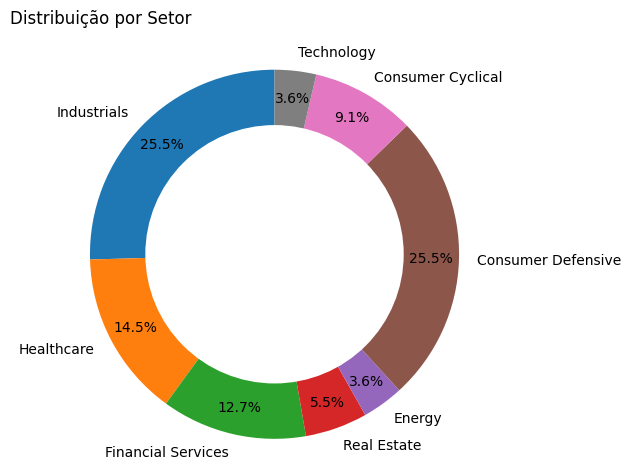

In [15]:
# Agrupar por setor e contar o número de empresas em cada um
sector_counts = data['Setor'].value_counts()

# Ordenar os dados de modo alternado entre setores grandes e pequenos
sorted_counts = pd.concat([pd.Series(sector_counts[::2]), pd.Series(sector_counts[1::4])])

# Criar gráfico de rosca
fig, ax = plt.subplots()
ax.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Igualar aspecto para garantir que a torta seja desenhada como um círculo
ax.axis('equal')

# Adicionar o título
plt.title("Distribuição por Setor", loc='left', pad=20)

plt.tight_layout()
plt.show()


##Análise Individual de ativos

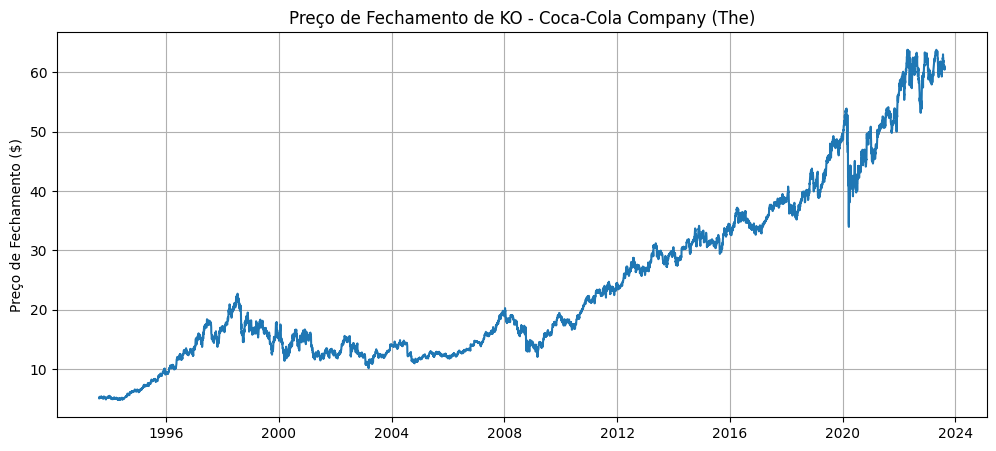

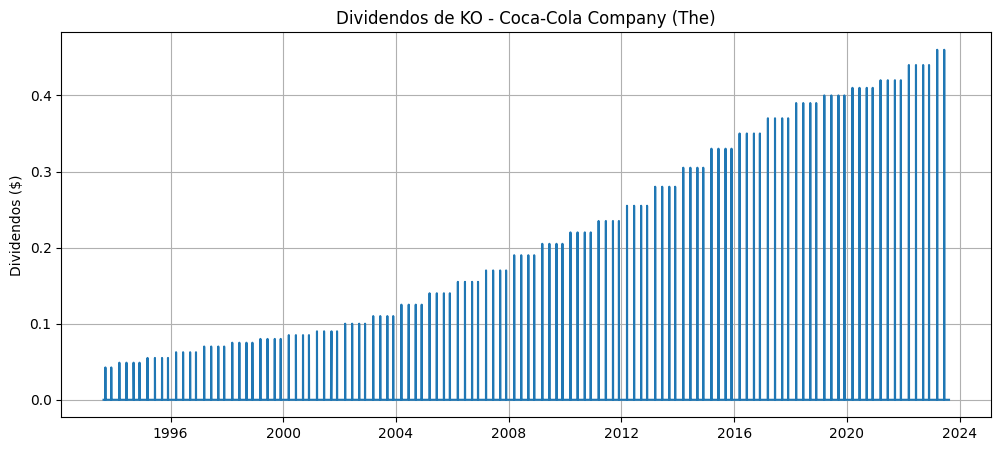

In [16]:
ativo = "KO" ### Insidra o ativo aqui!
# Baixar os dados do ETF
ticker = yf.Ticker(ativo)

# Obter o histórico de preços
history = ticker.history(period="30y")
# Obter o nome da empresa
company_name = ticker.info['shortName']

# Plotar o preço de fechamento
plt.figure(figsize=(12,5))
# plt.figure(figsize=(2,2))
plt.plot(history['Close'])
plt.title(f'Preço de Fechamento de {ticker.ticker} - {company_name}')  # Inclui o ticker e o nome da empresa no título
# plt.xlabel('Data')
plt.ylabel('Preço de Fechamento ($)')
plt.grid(True)
plt.show()

# # Plotar Dividendos
plt.figure(figsize=(12,5))
plt.plot(history.index, history['Dividends'])  # Mudamos a função plt.plot para plt.bar
plt.title(f'Dividendos de {ticker.ticker} - {company_name}')  # Inclui o ticker e o nome da empresa no título
# plt.xlabel('Data')
plt.ylabel('Dividendos ($)')
plt.grid(True)
plt.show()


##Indicadores

In [17]:

################################################################
ticker = yf.Ticker(ativo) # Define ticker
d_util = 252 # quantidade média de dias de mercado no ano
anos = 30
################################################################
# Get data from the last n years
end_date = datetime.today()
start_date = end_date - timedelta(days=anos*365)

data = ticker.history(start=start_date, end=end_date)
# data.head()

In [18]:
# Calcular os retornos logaritmicos diários
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Calcular o retorno anual e o desvio padrão anual
data['Year'] = data.index.year
annual_returns = data.groupby('Year')['Log Returns'].sum()
annual_std_dev = data.groupby('Year')['Log Returns'].std() * np.sqrt(d_util)

# Calcular o preço no final de cada ano
annual_price = data['Close'].resample('Y').last().reset_index()
annual_price['Year'] = annual_price['Date'].dt.year

# Criar um DataFrame para armazenar os resultados
annual_data = pd.DataFrame({
    'Annual Returns': annual_returns,
    'Annual Std Dev': annual_std_dev})

# Fazendo o merge de annual_data e annual_price no 'Year'
annual_data = pd.merge(annual_data, annual_price, on='Year')

# Removendo a coluna 'Date' de annual_price
annual_data.drop('Date', axis=1, inplace=True)


In [19]:
# Calcular os dividendos anuais por ação
annual_dividends = data['Dividends'].resample('Y').sum().reset_index()
annual_dividends['Year'] = annual_dividends['Date'].dt.year

# Juntar os dividendos ao dataframe annual_data
annual_data = pd.merge(annual_data, annual_dividends, on='Year')
# Removendo a coluna 'Date'
annual_data.drop('Date', axis=1, inplace=True)

# Calcular o Dividend Yield
annual_data['Dividend Yield'] = annual_data['Dividends'] / annual_data['Close']
# Calcular a taxa de crescimento de dividendos
annual_data['Dividend Growth Rate'] = annual_data['Dividends'].pct_change()


In [20]:
annual_data.rename(columns={
    'Year': 'Ano',
    'Annual Returns': 'Retorno Anual',
    'Annual Std Dev': 'DP Anual',
    'Close': 'Cotação',
    'Dividends': 'Dividendos',
    'Dividend Yield': 'DY',
    'Dividend Growth Rate': 'Tx Cresc Dividendos'
}, inplace=True)

annual_data.tail()

,Ano,Retorno Anual,DP Anual,Cotação,Dividendos,DY,Tx Cresc Dividendos
26,2019,0.187304,0.171196,49.630447,1.60,0.032238,0.025641
27,2020,0.024392,0.348486,50.855900,1.64,0.032248,0.025000
28,2021,0.107710,0.152617,56.639469,1.68,0.029661,0.024390
29,2022,0.100836,0.197638,62.648670,1.76,0.028093,0.047619
30,2023,-0.031424,0.124222,60.710602,0.92,0.015154,-0.477273


In [21]:

# Criar um subplot para cada coluna do DataFrame (exceto 'Ano')
fig = make_subplots(rows=len(annual_data.columns)-1, cols=1,
                    subplot_titles=[f'Acompanhamento de {col}' for col in annual_data.columns[1:]])

# Adicionar um gráfico de barras para cada coluna (exceto 'Ano')
for i, col in enumerate(annual_data.columns[1:], start=1):  # Começar do segundo campo
    # Separar valores positivos e negativos
    positive_values = annual_data[col].clip(lower=0)
    negative_values = annual_data[col].clip(upper=0)

    fig.add_trace(go.Bar(x=annual_data['Ano'], y=positive_values, name=col, marker_color='blue'),
                  row=i, col=1)

    fig.add_trace(go.Bar(x=annual_data['Ano'], y=negative_values, name=col, marker_color='red'),
                  row=i, col=1)

# Adicionar uma linha horizontal em y=0 para cada gráfico
for i in range(1, len(annual_data.columns)):  # Começar do segundo campo
    fig.add_shape(type="line",
                  x0=annual_data['Ano'].min(), x1=annual_data['Ano'].max(), y0=0, y1=0,
                  line=dict(color="Black",width=1),
                  row=i, col=1)

# Atualizar layout do gráfico
fig.update_layout(height=500*(len(annual_data.columns)-1), width=900,
                  title_text="Dashboard", showlegend=False)

# Salvar o gráfico como um arquivo HTML
fig.write_html("dashboard.html")


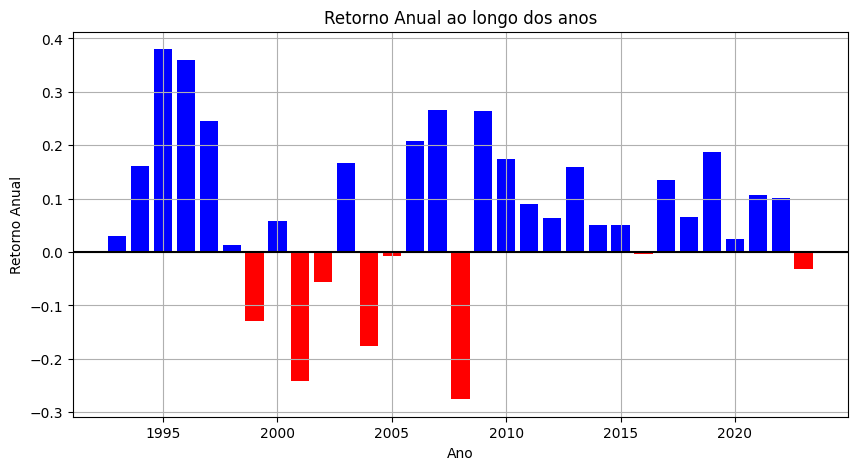

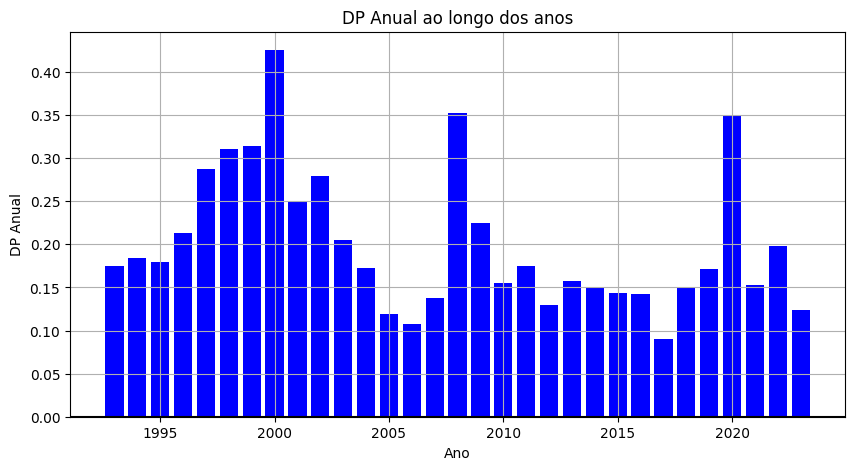

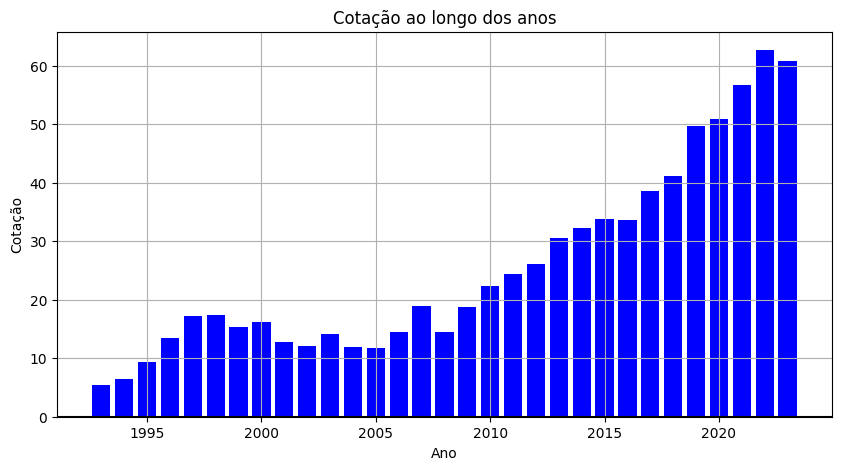

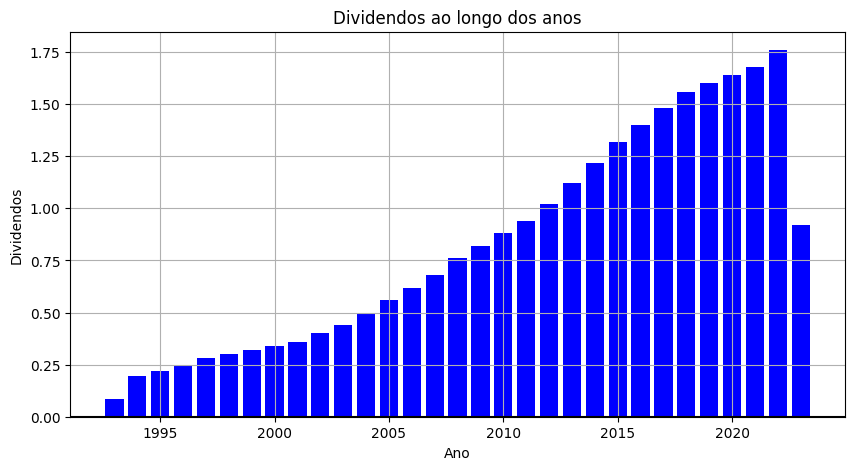

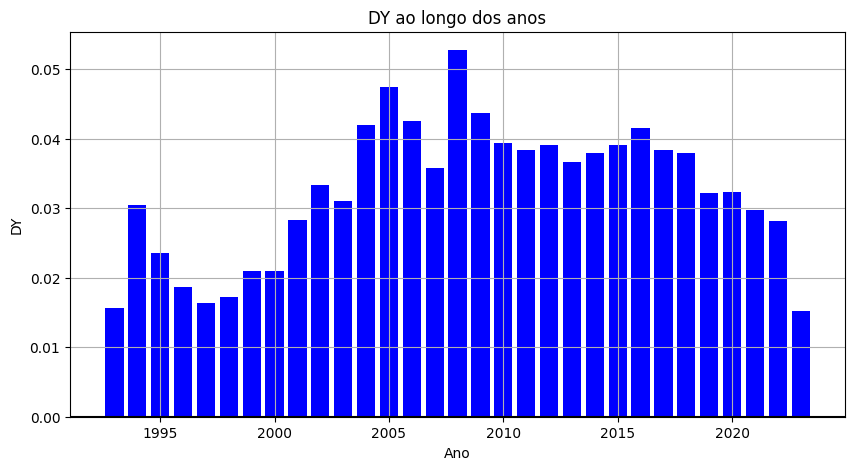

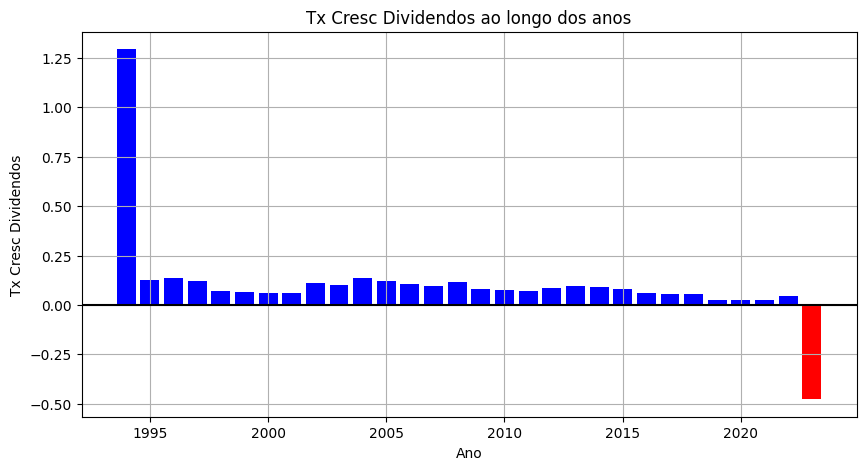

In [22]:

# Lista de todas as colunas que são ativos
assets = ['Retorno Anual', 'DP Anual', 'Cotação', 'Dividendos', 'DY', 'Tx Cresc Dividendos']

for asset in assets:
    plt.figure(figsize=(10,5))

    # condição para determinar as cores das barras
    colors = np.where(annual_data[asset]<0, 'r', 'b')

    plt.bar(annual_data['Ano'], annual_data[asset], color=colors)
    plt.axhline(0, color='black')  # adiciona uma linha horizontal no zero

    plt.xlabel('Ano')
    plt.ylabel(asset)
    plt.title(f'{asset} ao longo dos anos')
    plt.grid(True)

    plt.show()


##Formatar os dados finais para o dashboard
ATENÇÃO: os dados formatados não são apropriadas para manipulação, pois não são numéricos.

In [23]:
data_final = annual_data.copy()  # Faz uma cópia do DataFrame original para evitar a modificação do DataFrame original

# Multiplica os valores por 100 e arredonda para 2 casas decimais
data_final['Retorno Anual'] = data_final['Retorno Anual'].multiply(100).round(2)
data_final['DP Anual'] = data_final['DP Anual'].multiply(100).round(2)
data_final['DY'] = data_final['DY'].multiply(100).round(2)
data_final['Tx Cresc Dividendos'] = data_final['Tx Cresc Dividendos'].multiply(100).round(2)
data_final = data_final.fillna('')

# Adiciona o símbolo de porcentagem (%) ao final dos valores
data_final['Retorno Anual'] = data_final['Retorno Anual'].astype(str) + '%'
data_final['DP Anual'] = data_final['DP Anual'].astype(str) + '%'
data_final['DY'] = data_final['DY'].astype(str) + '%'
data_final['Tx Cresc Dividendos'] = data_final['Tx Cresc Dividendos'].astype(str) + '%'
# Formatando as colunas 'Cotação' e 'Dividendos'
data_final['Cotação'] = data_final['Cotação'].apply(lambda x: f'R$ {x:,.2f}')
data_final['Dividendos'] = data_final['Dividendos'].apply(lambda x: f'R$ {x:,.2f}')

data_final

,Ano,Retorno Anual,DP Anual,Cotação,Dividendos,DY,Tx Cresc Dividendos
0,1993,3.06%,17.48%,R$ 5.46,R$ 0.09,1.56%,%
1,1994,16.07%,18.4%,R$ 6.41,R$ 0.20,3.04%,129.41%
2,1995,37.98%,17.92%,R$ 9.37,R$ 0.22,2.35%,12.82%
3,1996,35.95%,21.29%,R$ 13.42,R$ 0.25,1.86%,13.64%
4,1997,24.58%,28.76%,R$ 17.16,R$ 0.28,1.63%,12.0%
5,1998,1.31%,31.1%,R$ 17.39,R$ 0.30,1.73%,7.14%
6,1999,-12.97%,31.47%,R$ 15.27,R$ 0.32,2.1%,6.67%
7,2000,5.81%,42.55%,R$ 16.19,R$ 0.34,2.1%,6.25%
8,2001,-24.16%,24.92%,R$ 12.71,R$ 0.36,2.83%,5.88%
9,2002,-5.65%,27.97%,R$ 12.01,R$ 0.40,3.33%,11.11%
